# **A Natural Language Processing & Sentiment Analysis on the Plot Summaries and Their Use in Predicting the Success of the Movies**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from string import punctuation
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import seaborn
seaborn.set()
import scipy.sparse
from sklearn.svm import SVC
from wordcloud import WordCloud

# Running time of this notebook would vary, but in general, it would take around 4 to 5 minutes

In [2]:
# Download NLTK packages.
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
    
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
    
# nltk.download()

In [3]:
omdb = pd.read_json("data/omdb-data.json.gz", lines=True)

In [4]:
rotten_tomatoes = pd.read_json("data/rotten-tomatoes.json.gz", lines=True)

# **Initial Data Processing**

In [5]:
# Filter out the punctuations and stop words.
def filter_words(words):
    tokens = word_tokenize(words)
    for i in range(len(tokens)):
        filtered_list = [string.lower().replace(r'[^\w\s\'-]', '') for string in tokens]
        filtered_list = [string for string in filtered_list if string not in stopwords.words('english')]
        return ' '.join(string for string in filtered_list)     

In [6]:
# A thing to note: Calling filter_words function would take around 3 to 4 minutes to finish.
omdb['omdb_plot'] = omdb['omdb_plot'].apply(lambda x: filter_words(x))

In [7]:
omdb['omdb_plot']

0       sprawling , star-laden film , see struggles va...
1       cryptic message past sends james bond rogue mi...
2       makers parody `` night living dead '' took geo...
3       jack crabb 121 years old film begins . collect...
4       perry girlfriend , gail , cross paths charisma...
5       protagonist alex delarge `` ultraviolent '' yo...
6       captain jack sparrow ( depp ) crosses paths wo...
7       early 60s france . remaining survivors aborted...
8       july 2nd , communications systems worldwide se...
9       paranoid brigadier general jack d. ripper burp...
10      english-language adaptation swedish novel stie...
11      england 's prince albert must ascend throne ki...
12      ancient ring thought lost centuries found , st...
13      depicting events gamma bomb . 'the incredible ...
14      english rock star aldous snow relapses drugs b...
15      tony stark creates ultron program protect worl...
16      benjamin franklin gates descends family treasu...
17      james 

# **Calculation of Polarity Scores Based on the Plot Summaries**

In [8]:
# Start the polarity score calculation by initializing an object of the sentiment analyzer class.
score_analyzer = SentimentIntensityAnalyzer()

In [9]:
# Returns the compound score of each plot.
# It is normalized to be between -1 being the highest negative score and +1 being the highest positive score possible.
def calculate_polarity_score(plot):
    polarity_score = score_analyzer.polarity_scores(plot)
    return polarity_score['compound']

In [10]:
# In the vaderSentiment document, it says:
# positive sentiment: compound score >= 0.5
# neutral sentiment: compound score between >=-0.5 and <=0.5
# negative sentiment: compound score <=-0.5

# I formed my own threshold and used the other information like 'neg', 'pos' scores to calculate
# how accurate my positive and negative polarity data are. After long hours of tweaking, we got the best possible
# results for each positive and negative words.
def measure_positive_accuracy(plots):
    positive_correct = number_of_positive_samples = 0
    for plot in plots:
        polarity_score = score_analyzer.polarity_scores(plot)
        if not polarity_score['neg'] > 0.1:
            if polarity_score['pos'] - polarity_score['neg'] > 0:
                positive_correct += 1
            number_of_positive_samples += 1
    
    print("Number of samples: {} with Positive Score Accuracy: {}%".format \
        (number_of_positive_samples, positive_correct / number_of_positive_samples * 100.0))

def measure_negative_accuracy(plots):
        negative_correct = number_of_negative_samples = 0
        for plot in plots:
            polarity_score = score_analyzer.polarity_scores(plot)
            if not polarity_score['pos'] > 0.1:
                if polarity_score['pos'] - polarity_score['neg'] <= 0:
                    negative_correct += 1
                number_of_negative_samples += 1
        print("Number of samples: {} with Negative Score Accuracy: {}%".format \
        (number_of_negative_samples, negative_correct / number_of_negative_samples * 100.0))

In [11]:
measure_positive_accuracy(omdb['omdb_plot'])
measure_negative_accuracy(omdb['omdb_plot'])

Number of samples: 3102 with Positive Score Accuracy: 78.36879432624113%
Number of samples: 3440 with Negative Score Accuracy: 92.5%


In [12]:
omdb['polarity_score'] = omdb['omdb_plot'].apply(lambda x: calculate_polarity_score(x))

In [13]:
# Categorize the plots into one of three categories: positive, negative and neutral.
def plot_categorization(plot):
        polarity_score = score_analyzer.polarity_scores(plot)
        if not polarity_score['neg'] > 0.1:
            if polarity_score['pos'] - polarity_score['neg'] > 0:
                return "positive"
        elif not polarity_score['pos'] > 0.1:
            if polarity_score['pos'] - polarity_score['neg'] <= 0:
                return "negative"
        else:
            return "neutral"

In [14]:
omdb['category'] = omdb['omdb_plot'].apply(lambda x: plot_categorization(x))

In [15]:
# Positive = 1
# Neutral = 0
# Negative = -1

def transform_category_into_numeric_category(category):
    if category == "positive":
        return 1
    elif category == "negative":
        return -1
    else:
        return 0

In [16]:
omdb['numerical_category'] = omdb['category'].apply(lambda x: transform_category_into_numeric_category(x))

In [17]:
# Drop rows with no audience_average ratings and exclude uncessary columns.
rotten_tomatoes = rotten_tomatoes[rotten_tomatoes['audience_average'].notnull()]
rotten_tomatoes = rotten_tomatoes[['audience_average', 'critic_average', 'imdb_id']]

In [18]:
joined = pd.merge(omdb, rotten_tomatoes, on=['imdb_id'])
joined

,imdb_id,omdb_awards,omdb_genres,omdb_plot,polarity_score,category,numerical_category,audience_average,critic_average
0,tt0060814,Nominated for 2 Oscars. Another 2 nominations.,"[Drama, History, War]","sprawling , star-laden film , see struggles va...",-0.7351,negative,-1,3.5,6.4
1,tt2379713,Won 1 Oscar. Another 7 wins & 32 nominations.,"[Action, Adventure, Thriller]",cryptic message past sends james bond rogue mi...,-0.6597,neutral,0,3.5,6.4
2,tt0230575,N/A,"[Comedy, Horror]",makers parody `` night living dead '' took geo...,0.0258,neutral,0,3.3,NaN
3,tt0065988,Nominated for 1 Oscar. Another 5 wins & 8 nomi...,"[Adventure, Comedy, Drama]",jack crabb 121 years old film begins . collect...,-0.6705,negative,-1,3.8,7.9
4,tt1995390,2 nominations.,"[Crime, Drama, Thriller]","perry girlfriend , gail , cross paths charisma...",0.8271,positive,1,3.2,6.0
5,tt0066921,Nominated for 4 Oscars. Another 9 wins & 19 no...,"[Crime, Drama, Sci-Fi]",protagonist alex delarge `` ultraviolent '' yo...,-0.9217,neutral,0,4.0,8.4
6,tt1298650,2 wins & 31 nominations.,"[Action, Adventure, Fantasy]",captain jack sparrow ( depp ) crosses paths wo...,0.7980,positive,1,3.5,5.0
7,tt0069947,Nominated for 1 Oscar. Another 1 win & 10 nomi...,"[Crime, Drama, Thriller]",early 60s france . remaining survivors aborted...,-0.9623,negative,-1,3.9,7.6
8,tt0116629,Won 1 Oscar. Another 34 wins & 34 nominations.,"[Action, Adventure, Sci-Fi]","july 2nd , communications systems worldwide se...",-0.9246,negative,-1,3.5,6.4
9,tt0057012,Nominated for 4 Oscars. Another 13 wins & 7 no...,"[Comedy, War]",paranoid brigadier general jack d. ripper burp...,-0.9934,negative,-1,4.2,9.1


In [19]:
# 1 means success
# 0 means average
# -1 means flop
def classify_success_avg_flop(average_score):
    if average_score > 3.5:
        return "1"
    elif average_score <= 3.5 and average_score >= 2.5:
        return "0"
    else:
        return "-1"

In [20]:
joined['success/average/flop'] = joined['audience_average'].apply(lambda x: classify_success_avg_flop(x))

In [21]:
df = joined[['omdb_plot', 'numerical_category']]
y = joined['success/average/flop']

# **Training the Data and Prediction**
**X Data Will Contain Two Features: (Plot, Positive/Negative/Neutral) and Y Data Will Be Success/Average/Flop)**

In [22]:
df_train, df_valid, y_train, y_valid= train_test_split(df, y)

In [23]:
# Getting the token counts for plots using the CountVectorizer
vectorizer = CountVectorizer(max_features = 10000)
vectorizer.fit(df_train.omdb_plot)
X_plot_train = vectorizer.transform(df_train.omdb_plot)
X_plot_valid = vectorizer.transform(df_valid.omdb_plot)

In [24]:
# Add one more feature named numerical_category to the train and test data set
X_category_train = np.atleast_2d(df_train.numerical_category.astype(int)).T
X_train = scipy.sparse.hstack((X_plot_train, X_category_train))

X_category_valid = np.atleast_2d(df_valid.numerical_category.astype(int)).T
X_valid = scipy.sparse.hstack((X_plot_valid, X_category_valid))

In [25]:
svc_model = SVC(kernel='linear', C=0.01)
svc_model.fit(X_train, y_train)
print(svc_model.score(X_train, y_train))
print(svc_model.score(X_valid, y_valid))

0.7130673164788304
0.6144358154408406


# **Analysis of the Final Result - Visualizations**

In [26]:
positive_words = []
negative_words = []
neutral_words = []
def divide_words_into_positive_negative_neutral_lists(plot):
    tokens = nltk.word_tokenize(plot)
    for w in tokens:
        polarity_score = score_analyzer.polarity_scores(w)
        if not polarity_score['neg'] > 0.1:
            if polarity_score['pos'] - polarity_score['neg'] > 0:
                positive_words.append(w)
        elif not polarity_score['pos'] > 0.1:
            if polarity_score['pos'] - polarity_score['neg'] <= 0:
                negative_words.append(w)
        else:
                neutral_words.append(w)

In [27]:
# This is calling the divide_words_into_positive_negative_neutral_lists function which is to
# classify words into the following three categories: positive, negative and neutral words.
# The output returns None below because I am just appending words to each lists and not returning anything.
joined['omdb_plot'].apply(lambda x: divide_words_into_positive_negative_neutral_lists(x))

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
8725    None
8726    None
8727    None
8728    None
8729    None
8730    None
8731    None
8732    None
8733    None
8734    None
8735    None
8736    None
8737    None
8738    None
8739    None
8740    None
8741    None
8742    None
8743    None
8744    None
8745    None
8746    None
8747    None
8748    None
8749    None
8750    None
8751    None
8752    None
8753    None
8754    None
Name: omdb_plot, Length: 8755, dtype: object

In [28]:
from wordcloud import WordCloud

# Generate the Word Cloud Diagram for visualization purpose
def create_wordcloud(data, title):
    word_cloud = WordCloud(max_words=150, background_color='white', max_font_size=35,scale=3).generate(str(data))
    word_cloud.recolor()
    fig = plt.figure(figsize=(15, 15))
    fig.suptitle(title, fontsize=15)
    fig.subplots_adjust(top=2.32)
    plt.axis('off')
    plt.imshow(word_cloud)
    plt.show()

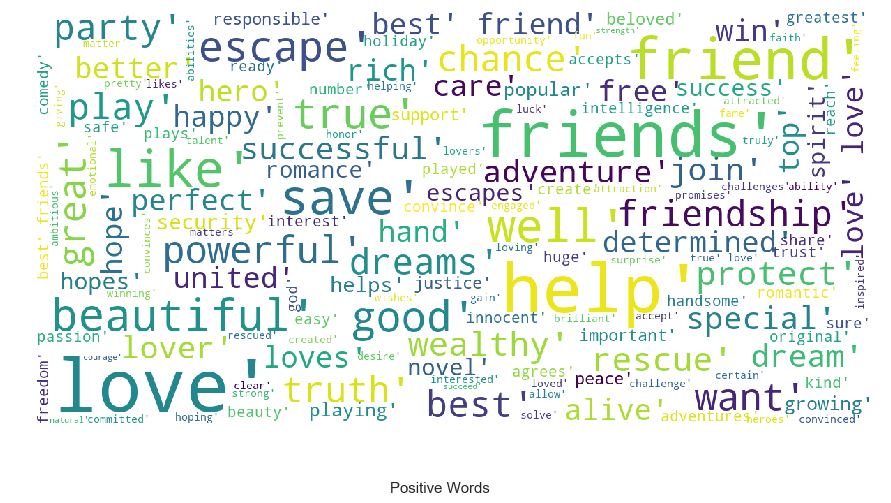

In [29]:
create_wordcloud(positive_words, "Positive Words")

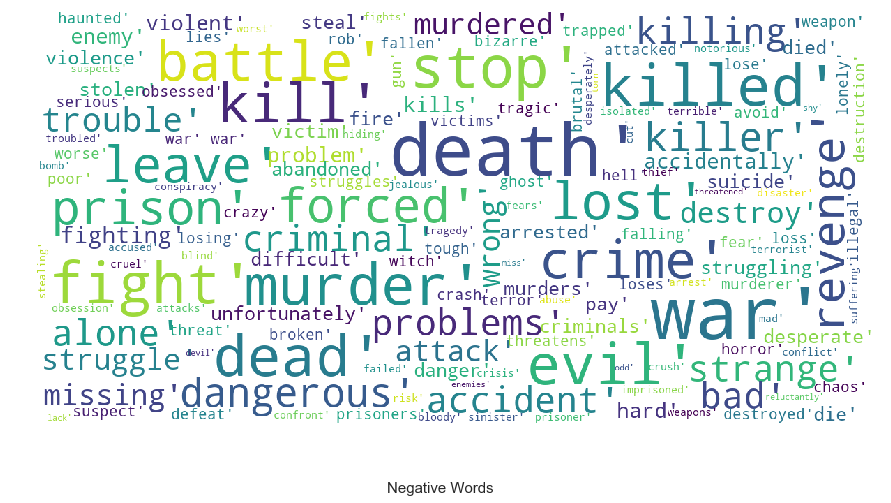

In [30]:
create_wordcloud(negative_words, "Negative Words")

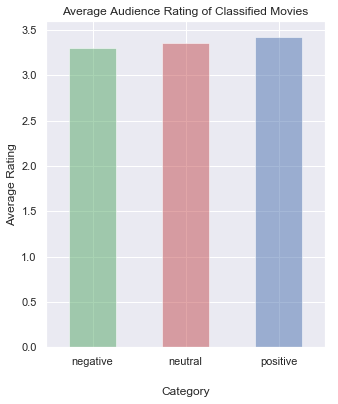

In [31]:
category_data = joined.groupby('category').agg('mean')
category_data = category_data[['audience_average', 'critic_average']]

custom_colors = ['g', 'r', 'b']
category_data['audience_average'].plot(kind='bar', alpha=0.5, figsize=(5, 6), color=custom_colors)
plt.xticks(rotation=0)
plt.title('Average Audience Rating of Classified Movies')
plt.xlabel('Category', labelpad=20)
plt.ylabel('Average Rating')
plt.show()

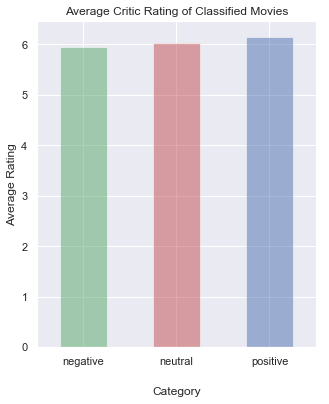

In [32]:
custom_colors = ['g', 'r', 'b']
category_data['critic_average'].plot(kind='bar', alpha=0.5, figsize=(5, 6), color=custom_colors)
plt.xticks(rotation=0)
plt.title('Average Critic Rating of Classified Movies')
plt.xlabel('Category', labelpad=20)
plt.ylabel('Average Rating')
plt.show()